## Replication Figure 3, [Online Surveillance and Wikipedia Use](https://drive.google.com/drive/folders/1QRoC6DAMoD_BxJ6KPMdijBRTDUYhoVfG)

### Requirements
- Well-commented code to create the figure or the table that you replicated
- Textual descriptions guiding through the process
- The figure/table that is the result of the replication
- Do not submit the data folder
- Output of each cell disposed

### Grading is based on:
- Quality of the textual descriptions
- Quality of code.
- Quality of replication

### Submission
- Replication report notebook (Jupyter notebook containing code, text, and the figure/table)
- You should fill a submission Google Form in time. In the form, you will provide a link to your repository.

## Preparations

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties
import pandas as pd
import seaborn as sns
import datetime

PRISM_DISCLOSURE = datetime.datetime(2013, 6, 6)  # The date when information about the PRISM program was disclosed in US media.

## Loading the data

After importing the necessary libraries, the first thing to do is loading the dataset and having a closer look.
Actually, before doing so, having a look at the raw csv file is always a good idea. This way, one can see that the data contain 'date' column, so importing it directly in the datetime format will make processing easier.

In [2]:
df = pd.read_csv('./data/terrorism_data.csv', index_col=0, parse_dates=[3], infer_datetime_format=True)
df.head()

,language,article,date,views
11000,en,abu_sayyaf,2012-01-01,254
1355,en,afghanistan,2012-01-01,5241
1369,en,agro,2012-01-01,27
1,en,al-qaeda,2012-01-01,2688
13457,en,al-qaeda_in_the_arabian_peninsula,2012-01-01,104


We can see the information contained in the data. The most important columns for this analysis will be **date** and **views**.

In [3]:
print("Languages in the dataset:", df.language.unique())
nr_articles = len(df.article.unique())
print("Number of different articles in the dataset:", nr_articles)
nr_days = (df.date.max()-df.date.min()).days + 1
print("Covered timespan: {} days between {} and {}.\n#Days * #Articles: {}".format(nr_days, df.date.min().strftime('%d-%m-%y'), df.date.max().strftime('%d-%m-%y'), nr_days * nr_articles))
zero_articledays = len(df.loc[df.views==0])
print("Zero-View articledays: {}. This is {} percent of the total covered articledays.".format(zero_articledays, round(100 * zero_articledays / (nr_articles * nr_days), 2)))
print("Dataset description:\n")

df.describe().transpose()

Languages in the dataset: ['en']
Number of different articles in the dataset: 48
Covered timespan: 974 days between 01-01-12 and 31-08-14.
#Days * #Articles: 46752
Zero-View articledays: 2971. This is 6.35 percent of the total covered articledays.
Dataset description:



,count,mean,std,min,25%,50%,75%,max
views,46752.0,1788.209617,3313.779104,0.0,102.0,346.0,2190.0,114282.0


Some short sanity checks:
- The data only contains english Articles (as desired), there are 48 different articles.
- The data covers 974 days. For every articleday (1 article at 1 date = 1 articledate), there is an entry.
- The mean view is significantly higher than the median view. We will come back to that later.
- 6.35% of the articledays have no page views at all. We will come back to that later as well.

## Design the plotting function which will later be used to visualize the date
For the analysis of the data, I want to create a scatter plot (with a discrete x-Axis) for the monthly total pageviews of the articles including a linear trend.
Seaborns regplot combines these features while providing an additional uncertainty bound.

In [4]:
def make_figure(in_frame, split_at=None, title='Article View Trends'):
    """
    Takes the input data and creates a plot similar to figure 3 in the paper.
    :param dataframe: A pandas data frame with the dates (dtype=PeriodIndex) as index and views as its only column
    :param split_at: The date at which the data shall be split
    :param title: Figure title
    :return: Plots the figure
    """
    
    # Prepare the dataframe for seaborn (https://stackoverflow.com/questions/52112979/having-xticks-to-display-months-in-a-seaborn-regplot-with-pandas)
    # Seaborh has issues handling datetimes, so for the computation they are transformed to integers before transforming them back for the labelling later on.
    # Matplotlib provides the necessary functionality.
    dataframe = in_frame.copy()
    dataframe.index = dataframe.index.to_timestamp()
    dataframe['date_ordinal'] = mdates.date2num(dataframe.index)
    
    # Some color definition for plotting and the legend
    colors = {'Monthly Page Views': 'blue', 'trend': 'grey'}
    
    # Starting to build the actual plot
    fig, ax = plt.subplots(figsize=[18, 6])
    if split_at is None:  # Just a simple regplot
        sns.regplot(x='date_ordinal', y='views', data=dataframe, ax=ax, color=colors['Monthly Page Views'])
    else:  # Splitting at a given date to create two trend lines within one plot as in the paper.
        colors['Prism Disclosure, 6/6/2013'] = 'red'
        df1 = dataframe.loc[dataframe.index < split_at]
        df2 = dataframe.loc[dataframe.index >= split_at]
        sns.regplot(x='date_ordinal', y='views', data=df1, ax=ax, color=colors['Monthly Page Views'],
                    scatter_kws={'color': colors['Monthly Page Views'], 's': 30},
                    line_kws={'color': colors['trend']})
        sns.regplot(x='date_ordinal', y='views', data=df2, ax=ax, color=colors['Monthly Page Views'],
                    scatter_kws={'color': colors['Monthly Page Views'], 's': 30},
                    line_kws={'color': colors['trend']})
        ax.vlines(mdates.date2num(split_at), 0, 1, color=colors['Prism Disclosure, 6/6/2013'], transform=ax.get_xaxis_transform(), label=split_at)
    
    # Formatting and Optics
    fig.patch.set_facecolor('lightgrey')
    fig.suptitle(title)
    ax.set_xlabel('Month / Year')
    ax.set_ylabel('Monthly Page Views')
    ax.set_xlim(dataframe['date_ordinal'].min() - 15, dataframe['date_ordinal'].max() + 15)
    
    # As mentioned above, the date was transformed to integers for the sake of plotting it using seaborn.
    # Now, they have to be transformed back to have nice x-Axis labels that are human-readable
    loc = mdates.MonthLocator()
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
    
    # Add a custom legend
    legend_patches = []
    for entry, c in colors.items():
        legend_patches.append(mpatches.Patch(color=c, label=entry))
    legend_patches.append(mpatches.Patch(color='lightgrey', label='95% Confidence Interval'))
    font = FontProperties()
    font.set_size('large')
    fig.autofmt_xdate()
    plt.legend(handles=legend_patches, title='Legend', bbox_to_anchor=(0, 0), loc='lower left', prop=font,
               ncol=len(legend_patches) // 2, fancybox=True, shadow=True)

## Analyze data and build the first plot
After setting up the plotting function, the data can now be visualized. To do so, the views have to be grouped by month and the resulting dataframe can be plugged into the defined function.

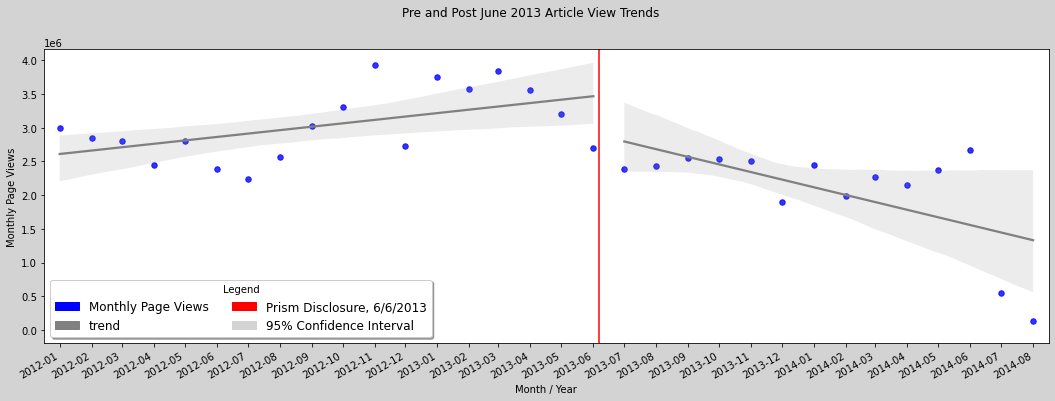

In [5]:
df_months = df.copy()
df_months['date'] = df['date'].dt.to_period('M')  # Reduction to month/year
monthly_views = df_months.groupby('date').sum()  # Get monthly views
make_figure(monthly_views, split_at=PRISM_DISCLOSURE, title='Pre and Post June 2013 Article View Trends')

## Having a closer look at the underlying data
The plot looks already quite similar to the one in tha paper. The total pageviews per month are between 2e6 and 4e6 most of the time and a change in the overall trend can clearly be seen.
However though, the two datapoints for **July 2014** and **August 2014** look weird. They are way below the other monthly page views. This leads to a suspiciously broad confidence interval in the right part of the plot. Also, the report in the paper does not show such a drop in views which brings me to the assumption there might be something wrong with *my* data.

As mentioned in the sanity check in the beginning, more than 6% of the articledays in the data have 0 pageviews. They might be an explanation for an overall little total in a month if unevenly distributed, so lets visualize their distribution in the given time range.

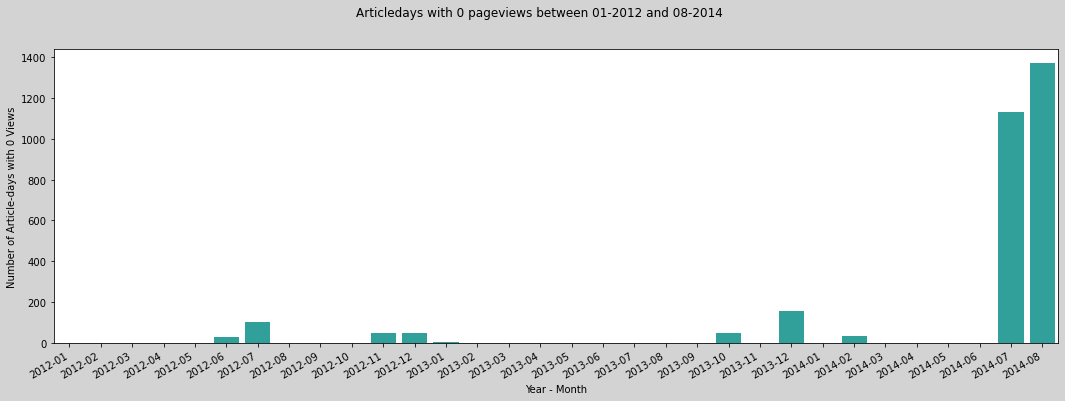

In [6]:
# Count the articledays with 0 views
no_views = df_months[['views', 'date']].loc[df_months['views'] == 0].groupby('date').count()

# Some months might not appear in the dataframe created above (every article has >0 views), so let's put them back in
for month in df_months['date'].unique():
    if month in no_views.index.tolist():
        pass
    else:
        no_views = no_views.append(pd.DataFrame([0], [month]))
no_views.sort_index(inplace=True)

# Create a barplot to show the results
fig, ax = plt.subplots(figsize=[18, 6])
fig.patch.set_facecolor('lightgrey')
fig.suptitle('Articledays with 0 pageviews between 01-2012 and 08-2014')
sns.barplot(x=no_views.index, y=no_views['views'], data=no_views, ax=ax, color='lightseagreen')
ax.set_xlabel("Year - Month")
ax.set_ylabel("Number of Article-days with 0 Views")
fig.autofmt_xdate()

So that's an interesting result! Almost all of the datapoints with 0 views are in July and August 2014. Because there is no such behaviour in the paper I want to reproduce I will assume those outliers are created by errors in the data. This might, for example, be caused by a corrupted data scraping process.

For the following analysis, those outliers will be ignored to realize a plot of the real trends in page views.

#### Looking for more outliers
As mentioned in the beginning, the median of the view feature in the dataset was way below the average, so let's have a look at the view distribution. As the view distribution seems to follow a power law, the plot shows the cumulative number of articles reaching a certain amount of views.

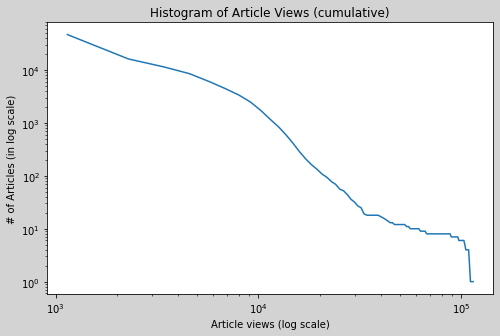

In [7]:
cumulative = plt.hist(df.views, bins=100, log=True, cumulative=-1, histtype='step')
plt.close()  # The above function is only needed to create the data in the format needed for plotting. Visualization happens below
fig, ax = plt.subplots(figsize=[8, 5])
fig.patch.set_facecolor('lightgrey')
ax.loglog(cumulative[1][1:],cumulative[0])
ax.set_title('Histogram of Article Views (cumulative)')
ax.set_ylabel('# of Articles (in log scale)')
ax.set_xlabel('Article views (log scale)')
plt.show()

The distribution of the article views almost seems to follow a power law, although not perfectly linear in a log-log scale. There is more extremely often visited articles than I would expect. To get more insights on those, let's have a look at the 15 dataset points with the highest view count:

In [8]:
df[['views', 'article', 'date']].sort_values(by='views', ascending=False).head(15).transpose()

,32521,32223,32421,32125,32111,32621,32021,32321,7467,849,3228,32721,83918,127741,7907
views,114282,108694,108280,107981,103249,102207,95415,87982,65375,60804,54643,51837,44924,42517,41976
article,hamas,hamas,hamas,hamas,pakistan,hamas,hamas,hamas,pakistan,al-qaeda,pakistan,hamas,ammonium_nitrate,nigeria,pakistan
date,2012-11-20 00:00:00,2012-11-17 00:00:00,2012-11-19 00:00:00,2012-11-16 00:00:00,2012-11-16 00:00:00,2012-11-21 00:00:00,2012-11-15 00:00:00,2012-11-18 00:00:00,2013-01-15 00:00:00,2013-04-28 00:00:00,2012-11-17 00:00:00,2012-11-22 00:00:00,2013-04-18 00:00:00,2014-06-30 00:00:00,2013-02-28 00:00:00


This table is heavily dominated by the **hamas article in November 2012**. Before jumping to conclusions, lets see the development of the hamas article throughout the given time frame.
Also, let's compare it with the second article that appears frequently in the top 15-table, the **pakistan** article:

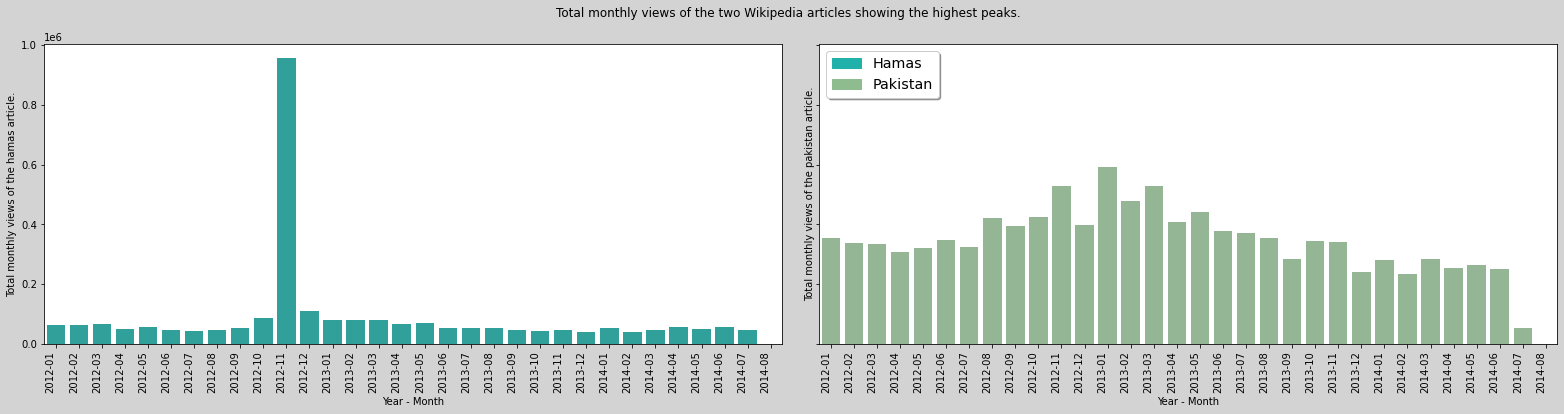

In [9]:
# Get monthly page views for distinct articles only
hamas = df_months[['article', 'views', 'date']].loc[df_months['article'] == 'hamas'].groupby('date').sum()
pakistan = df_months[['article', 'views', 'date']].loc[df_months['article'] == 'pakistan'].groupby('date').sum()

# And visualize them next to each other in bar plots.
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=[22, 6])
sns.barplot(x=hamas.index, y=hamas['views'], ax=ax1, color='lightseagreen')
sns.barplot(x=pakistan.index, y=pakistan['views'], ax=ax2, color='darkseagreen')
fig.patch.set_facecolor('lightgrey')
fig.suptitle('Total monthly views of the two Wikipedia articles showing the highest peaks.')
ax1.set_xlabel("Year - Month")
ax2.set_xlabel("Year - Month")
ax1.set_ylabel("Total monthly views of the hamas article.")
ax2.set_ylabel("Total monthly views of the pakistan article.")
fig.tight_layout()

# Make clear, which plot shows what
plt.legend(handles=[mpatches.Patch(color='lightseagreen', label='Hamas'), mpatches.Patch(color='darkseagreen', label='Pakistan')],
          loc='upper left', prop={'size': 'x-large'}, fancybox=True, shadow=True)
fig.autofmt_xdate(rotation=90)

## Analyse and remove the outliers and build the actual plot

The hamas article reaches almost 1.000.000 views in November 2012! In comparison to the other months and to the pakistan article, the anomaly can easily be spotted. This effect was also discovered in the paper and explained by the temporal correlation to the Isrealie “Operation Pillar of Defense”. The pageviews by the hamas article for that month make up a significant amount of the total pageviews in November 2012 (more than 20%). This is clearly another outlier, so it will be removed in the following analysis.

Finally, I also remove data for July 2013. It is not an outlier, but also cannot clearly be assigned to the pre- or post-PRISM time, as the prism disclosure happened during this month. For a distinct analysis of the time before and after the revellation it seems to be more precise to analyze only months which fall into those time frames completely.

Note also: The paper reported a similar increase in hamas page views in July 2014. The relatively low number of views in the dataset being inspected here for both, the hamas and the pakistan articles, further support the theory of faulty data for those months.

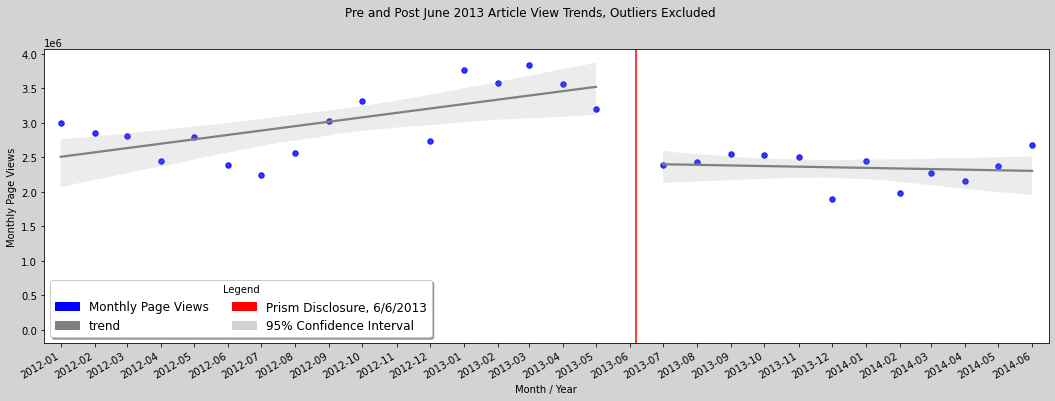

In [10]:
# Due to the index format of the monthly_views dataframe, to remove certain months, a simple slicing using dates and pandas *loc* can be used here.
final = pd.concat([monthly_views.loc[:datetime.date(2012, 10, 31)], monthly_views.loc[datetime.date(2012, 12, 1):datetime.date(2013, 5, 31)],
                   monthly_views.loc[datetime.date(2013, 7, 1):datetime.date(2014, 6, 30)]])
make_figure(final, split_at=PRISM_DISCLOSURE,
            title='Pre and Post June 2013 Article View Trends, Outliers Excluded')

## Discussion

After removing the outliers and June 2013, the first thing to note is the narrower confidence intervals. The linear trend line seems to explain the view development better than in the beginning. But do the results show a *chilling effect*?

On one hand, yes: The trend before June 2013 was clearly upward, albeit only slightly. The total monthly views of the articles has been greater than 3.000.000 for 5 subsequent months before information about the PRISM programme was released. This number of views was not reached again in the second half of the analyzed time frame. Also, the trend after June 2013 is clearly staying constant. It looks like the trend of rising page views was stopped by the revelations in addition to a sudden and permanent drop of around 1.000.000 total views.

On the other hand, the paper whose results shall be reproduced here presented a significantly more extreme change in trends and total views. The analysis performed here can only partially support those findings. Most importantly, a falling trend after June 2013 could not be reproduced. The theory of a real chilling effect, meaning a **long-term decrease in traffic**, can not be empirically proven by this analysis.

## Second Replication: Including the Domestic Security Comparator Group

In the second part of this analysis, a comparison between articles from the Terrorism domain and a comparator group, a set of Wikipedia articles in the categories "DHS & Other Agencies" and "Infrastructure Security", shall be performed. Articles from the comparator group include topics as "Secret Service", "Air Marshal" or "United Nations".

From here on, the terror dataset consists of 30 different articles, a subset of the articles with the highes "privacy score" (probably raising higher privacy concerns) amongst the ones used in the analysis above.

The theory of chilling effect states that Wikipedia users viewing terrorism-related articles should be more chilled by the PRISM revelations as users looking up information about similar topics (security, infrastructure, ...) that is not coupled to privacy concerns to the same extent. This theory shall be tested in the following:

In [11]:
# Again, first things first: Load the Data
terror = pd.read_csv('./data/terrorism_data_30.csv', index_col=0, parse_dates=[3], infer_datetime_format=True)
comp = pd.read_csv('./data/domestic_data.csv', index_col=0, parse_dates=[3], infer_datetime_format=True)
comp.head()

,language,article,date,views
1900,en,air_marshal,2012-01-01,383
1590,en,alcohol_and_tobacco_tax_and_trade_bureau,2012-01-01,64
1349,en,border_patrol,2012-01-01,38
1358,en,bureau_of_land_management,2012-01-01,135
1390,en,central_intelligence_agency,2012-01-01,2964


### Some insights on the two data sets:

In [12]:
# Total number of articles and nan-Values in both sets:
terror_articles = terror.article.unique()
comp_articles = comp.article.unique()
print("The terrorism group contains {} articles. The comparator group contains {} articles.".format(len(terror_articles), len(comp_articles)))
nans = terror.views.isna().sum() + comp.views.isna().sum() or 'no'
print("There are {} nan-Values in both groups comnined.".format(nans))

# Check whether the datasets cover the same time frame
assert set(terror.date.unique()) == set(comp.date.unique())

# Count the number of "zero articledays" in both datasets.
terror0ad = len(terror.loc[terror.views==0])
comp0ad = len(comp.loc[comp.views==0])
print("Zero-View articledays: {}.".format(terror0ad + comp0ad))

print('-' * 30 + "Terror Dataset" + '-' * 30 + '\n', terror.describe().transpose())
print('-' * 28 + "Comparator Dataset" + '-' * 28 + '\n', comp.describe().transpose())

The terrorism group contains 30 articles. The comparator group contains 25 articles.
There are no nan-Values in both groups comnined.
Zero-View articledays: 3433.
------------------------------Terror Dataset------------------------------
          count        mean          std  min   25%    50%    75%      max
views  29220.0  876.474743  1628.164585  0.0  75.0  226.0  810.0  60804.0
----------------------------Comparator Dataset----------------------------
          count         mean         std  min   25%    50%    75%      max
views  24350.0  1069.245749  2801.86325  0.0  64.0  267.0  836.0  76844.0


## Design of the Plotting Function

The plot for the second part of the replication will be quite similar to the first one (see above).
Nevertheless, there are some changes, like including 2 trends instead of only one, so I will define a new function in the following.
The code is mostly duplicated to achieve a similar behaviour.

In [13]:
def make_double_figure(in_frames, names, split_at=PRISM_DISCLOSURE, title='Terrorism Articles Study Group vs. Domestic Security Comparator Group'):
    """
    Takes the input data and creates a plot similar to figure 4a in the paper.
    :param dataframes: An iterable of 2 pandas data frames with the dates (dtype=PeriodIndex) as index and views as only column
    :param names: Names for the incoming data frames (neede for the legend)
    :param split_at: The date at which the data shall be split
    :param title: Figure title
    :return: Plots the figure
    """
    
    assert len(in_frames) == 2, "You are using the wrong function to plot my friend."  # This won't work otherwise
    dfs_to_plot = []
    for in_frame in in_frames:
        # Prepare the dataframe for seaborn (https://stackoverflow.com/questions/52112979/having-xticks-to-display-months-in-a-seaborn-regplot-with-pandas)
        # Seaborh has issues handling datetimes, so for the computation they are transformed to integers before transforming them back for the labelling later on.
        # Matplotlib provides the necessary functionality.
        dataframe = in_frame.copy()
        dataframe.index = dataframe.index.to_timestamp()
        dataframe['date_ordinal'] = mdates.date2num(dataframe.index)
        dfs_to_plot.append(dataframe)
    
    # Some color definition for plotting and the legend
    colors = {names[0]: 'blue', names[1]: 'green', 'Prism Disclosure, 6/6/2013': 'red'}
    
    # Starting to build the actual plot
    fig, ax = plt.subplots(figsize=[18, 6])

    for i, dataframe in enumerate(dfs_to_plot):
        # The df has to be seperated in BEFORE and AFTER the split_date (PRISM disclosure).
        before = dataframe.loc[dataframe.index < split_at]
        after = dataframe.loc[dataframe.index >= split_at]
        sns.regplot(x='date_ordinal', y='views', data=before, ax=ax, color=colors[names[i]],
                    scatter_kws={'color': colors[names[i]], 's': 30},
                    line_kws={'color': 'dark' + colors[names[i]]})
        sns.regplot(x='date_ordinal', y='views', data=after, ax=ax, color=colors[names[i]],
                    scatter_kws={'color': colors[names[i]], 's': 30},
                    line_kws={'color': 'dark' + colors[names[i]]})
    
    ax.vlines(mdates.date2num(split_at), 0, 1, color=colors['Prism Disclosure, 6/6/2013'], transform=ax.get_xaxis_transform(), label=split_at)
    
    # Formatting and Optics
    fig.patch.set_facecolor('lightgrey')
    fig.suptitle(title)
    ax.set_xlabel('Month / Year')
    ax.set_ylabel('Monthly Page Views')
    # Dataframe will be defined as the working version of in_frame #2, so the line below should work just fine
    ax.set_xlim(dataframe['date_ordinal'].min() - 15, dataframe['date_ordinal'].max() + 15)
    
    # As mentioned above, the date was transformed to integers for the sake of plotting it using seaborn.
    # Now, they have to be transformed back to have nice x-Axis labels that are human-readable
    loc = mdates.MonthLocator()
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
    
    # Add a custom legend
    legend_patches = []
    for entry, c in colors.items():
        legend_patches.append(mpatches.Patch(color=c, label=entry))
    # legend_patches.append(mpatches.Patch(color='lightgrey', label='95% Confidence Interval'))
    font = FontProperties()
    font.set_size('large')
    fig.autofmt_xdate()
    plt.legend(handles=legend_patches, title='Legend', bbox_to_anchor=(0, 0), loc='lower left', prop=font,
               ncol=len(legend_patches) // 1, fancybox=True, shadow=True)

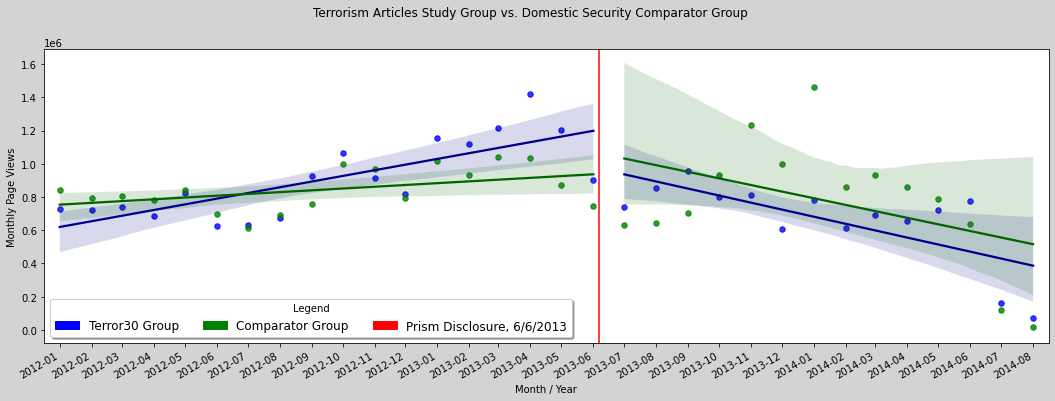

In [14]:
dfs_to_plot = [terror.copy(), comp.copy()]
for i, df in enumerate(dfs_to_plot):
    df['date'] = df['date'].dt.to_period('M')  # Reduction to month/year
    dfs_to_plot[i] = df.groupby('date').sum()  # Get monthly views
    
make_double_figure(dfs_to_plot, ('Terror30 Group', 'Comparator Group'))

## Removing Outliers, again
There are quite a few suspicous data points in the first plot, created above. First of all, the low page view numbers for July and August 2014 indicate there might be a similar data leak / missing data as for the full 48 terrorism-related articles. This will be analysed in step I. Also, the pageviews for the comparator group in November 2013 and January 2014 are suspiciously high. The distribution of views for this month will be analyzed in step II. Finally, in step III, an analysis of the data in April 2013 in the terror dataset which seems suspiciously high will be conducted.

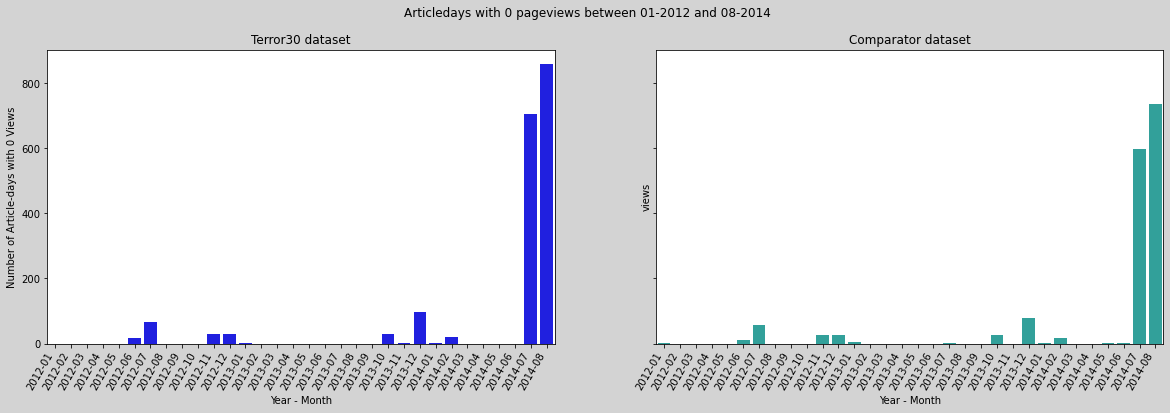

In [15]:
# Group the datasets in months
terrorM = terror.copy()
terrorM['date'] = terrorM['date'].dt.to_period('M')
compM = comp.copy()
compM['date'] = compM['date'].dt.to_period('M')

# Step 1: Count the articledays with 0 views
no_terror = terrorM[['views', 'date']].loc[terrorM['views'] == 0].groupby('date').count()
no_comp = compM[['views', 'date']].loc[compM['views'] == 0].groupby('date').count()

# Some months might not appear in the dataframe created above (every article has >0 views), so let's put them back in
for month in df_months['date'].unique():
    if month not in no_terror.index.tolist():
        no_terror = no_terror.append(pd.DataFrame([0], [month]))
    if month not in no_comp.index.tolist():
        no_comp = no_comp.append(pd.DataFrame([0], [month]))
no_terror.sort_index(inplace=True)
no_comp.sort_index(inplace=True)

# Create a barplot to show the results
fig, axs = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=[20, 6])
fig.patch.set_facecolor('lightgrey')
fig.suptitle('Articledays with 0 pageviews between 01-2012 and 08-2014')
sns.barplot(x=no_terror.index, y=no_terror['views'], data=no_terror, ax=axs[0], color='blue')
sns.barplot(x=no_comp.index, y=no_comp['views'], data=no_comp, ax=axs[1], color='lightseagreen')
axs[0].set_title('Terror30 dataset')
axs[1].set_title('Comparator dataset')
axs[0].set_xlabel("Year - Month")
axs[1].set_xlabel("Year - Month")
axs[0].set_ylabel("Number of Article-days with 0 Views")
fig.autofmt_xdate(rotation=60)

Clearly, also the two datasets used in this part of the paper replication suffer from missing data in the last two months of the covered time range. As before, those "outlier" months will be removed for the final analysis.

In [16]:
# Step 2, The comparator group in January 2014
# First, let's check which articles where the ones that led to the suspiciously high view count:
jan14 = compM.loc[compM.date == '2014-01']
jan14counts = sorted([(article, jan14.loc[jan14.article == article].views.sum()) for article in comp.article.unique()], key=lambda x: x[1], reverse=True)
total_in_jan14 = sum([count for _, count in jan14counts])

print("Page views in January 14:", total_in_jan14)
print("The most 5 commonly visited articles and their page counts are: [% of total monthly]")
for article, views in jan14counts[:5]:
    print(article, ':', views, '[ {}% ]'.format(round(100 * views / total_in_jan14, 2)))

Page views in January 14: 1459295
The most 5 commonly visited articles and their page counts are: [% of total monthly]
united_nations : 1013065 [ 69.42% ]
central_intelligence_agency : 102999 [ 7.06% ]
federal_bureau_of_investigation : 75887 [ 5.2% ]
espionage : 44768 [ 3.07% ]
united_states_department_of_homeland_security : 38128 [ 2.61% ]


Clearly, the United Nations Article dominates that month. But is this due to a general popularity of the UN article or is it an outlier?

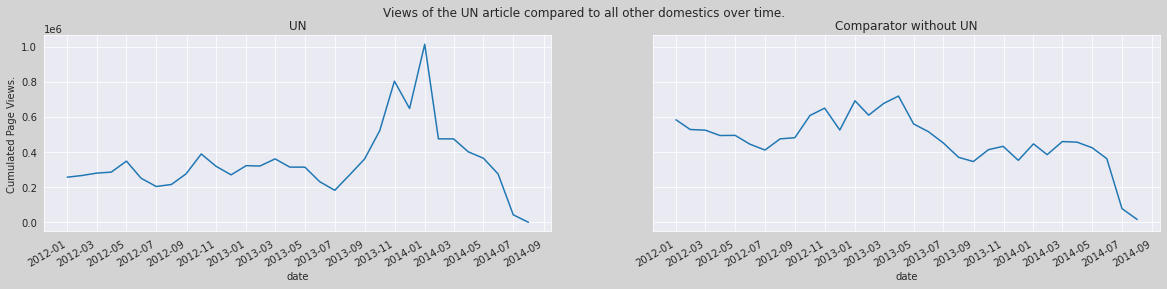

In [17]:
UN = compM.loc[compM.article == 'united_nations'].groupby('date').sum()
all_but_UN = compM.loc[compM.article != 'united_nations'].groupby('date').sum()
# Apparently there seems to be a non-fixed bug in the month locator shifting the dates by 1 month in some cases using panda, therefore the manuel '-30' here.
UN['date'] = mdates.date2num(UN.index) - 30
all_but_UN['date'] = mdates.date2num(all_but_UN.index) - 30
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(ncols=2, sharey=True, figsize=[20, 4])
    fig.patch.set_facecolor('lightgrey')
    fig.suptitle('Views of the UN article compared to all other domestics over time.')
    sns.lineplot(x='date', y='views', data=UN, ax=axs[0])
    sns.lineplot(x='date', y='views', data=all_but_UN, ax=axs[1])
    axs[0].set_title('UN')
    axs[1].set_title('Comparator without UN')
    axs[0].set_ylabel("Cumulated Page Views.")
    loc = mdates.MonthLocator(interval=2)
    axs[0].xaxis.set_major_locator(loc)
    axs[1].xaxis.set_major_locator(loc)
    axs[0].xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
    axs[1].xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
    fig.autofmt_xdate()

As can be seen, the UN article indeed has a significant peak in pageviews between 11/2013 and 01/2014 that does not show in the other articles of the domesti group. However, it seems hard to find a valid explanation for that. To my knowledge, no single event during that time frame would explain the sudden gain in interest. Also, the paper whose results shall be replicated reports significant outliers for the UN article as well and removes them without further argumentation. I want to catch up on that and explain why removing the UN data seems to be the better choice for me before doing so:

The idea behind this analysis is a comparison between terrorism-related articles and a comparator group of articles in a similar domain that cause less privacy concerns. To be effective, the comparator group should represent a "standard" behaviour of the articles within the given time frame. The United Nations article makes up more than half of the total cumulate page views in the comparator group in certain months. This makes the analysis prone to errors, as the data become dominated by a single article and therefore can be disturbed by changes in just one topic. I therefore chose to exclude the UN article in the following analysis to simulate a representative behaviour for "domestic" articles over all.

In [18]:
# Step 3, The terror group in April 2013
# First, let's check which articles where the ones that led to the suspiciously high view count:
apr13 = terrorM.loc[terrorM.date == '2013-04']
apr13counts = sorted([(article, apr13.loc[apr13.article == article].views.sum()) for article in terror.article.unique()], key=lambda x: x[1], reverse=True)
total_in_apr13 = sum([count for _, count in apr13counts])

print("Page views in April 13:", total_in_apr13)
print("The most 5 commonly visited articles and their page counts are: [% of total monthly]")
for article, views in apr13counts[:5]:
    print(article, ':', views, '[ {}% ]'.format(round(100 * views / total_in_apr13, 2)))

Page views in April 13: 1418566
The most 5 commonly visited articles and their page counts are: [% of total monthly]
al-qaeda : 318672 [ 22.46% ]
jihad : 207509 [ 14.63% ]
terrorism : 199149 [ 14.04% ]
taliban : 143895 [ 10.14% ]
improvised_explosive_device : 136743 [ 9.64% ]


Same procedure as before, check the al-qaeda behaviour:

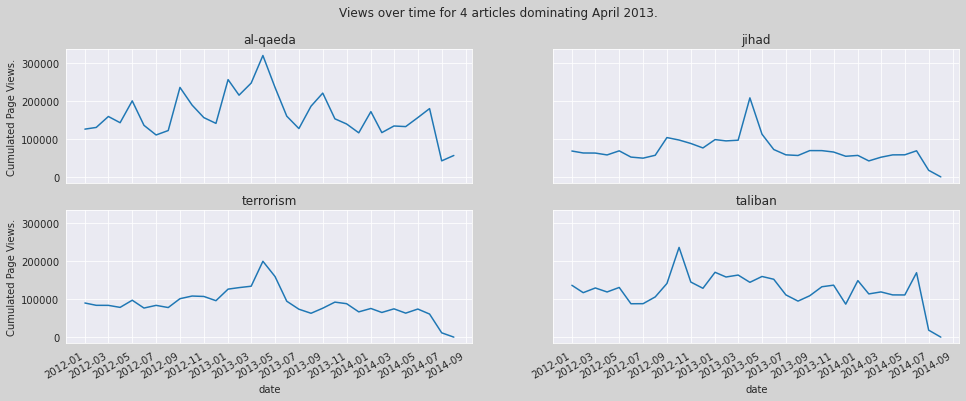

In [19]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=[16, 6])
    fig.patch.set_facecolor('lightgrey')
    fig.suptitle('Views over time for 4 articles dominating April 2013.')
    for i, article in enumerate(apr13counts[:4]):
        ROW = i // 2
        COL = i % 2
        ax = axs[ROW, COL]
        article = article[0] # Unpack, we don't need the count
        article_df = terrorM.loc[terrorM.article == article].groupby('date').sum()
        article_df['date'] = mdates.date2num(UN.index) - 30
        sns.lineplot(x='date', y='views', data=article_df, ax=ax)
        ax.set_title(article)
        ax.set_ylabel("Cumulated Page Views.")
        loc = mdates.MonthLocator(interval=2)
        ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
        fig.autofmt_xdate()

The plot shows the four articles that make up more than 50% of the overal views in April 2013 in the terror dataset. It is clearly visible that there are peaks in "Al-qaeda", "jihad" and "terrorism". At the 15th April 2013, a terror attack at the Marathon in Boston shocked people in America and all around the world. It seems that this major event caused significantly higher lookups of related Wikipedia articles. Because we are interested in long-term chilling effects, it should be valid to remove data from April 2013 in the analysis as this event is clearly an exception.

## Outliers: Conclusion & Removal
- Step 1 showed that, as in the first part of the reproduction, the datasets are incomplete for the last two months of the analysis. July and August 2014 will be excuded from the following analysis
- Step 2 showed that the UN article dominates the domestic comparator group. Because we are interested in an overall trend and not a comparison to one major article only, the UN article will be removed in the following. 
- Step 3 showed that there is a peak in page views for the terror dataset in April 2013, caused by the attack on the Boston Marathon. The month will be consideren an outlier and removed in the following.
- As in the first part of the analysis, I will not consider the July 2013 data as it falls into both, the pre- and the post-PRISM timeframe.

In [20]:
# Remove the UN articles
compM.drop(compM.loc[compM.article == 'united_nations'].index, inplace=True)

# From here on, we only care about monthly views overall only, not the individual article views.
terrorM = terrorM.groupby('date').sum()
compM = compM.groupby('date').sum()

# Removing April/June 2013 and July/August 2014 from the terror Dataset
terrorFinal = pd.concat([terrorM.loc[:datetime.date(2013, 3, 31)], terrorM.loc[datetime.date(2013, 5, 1):datetime.date(2013, 5, 31)],
                         terrorM.loc[datetime.date(2013, 7, 1):datetime.date(2014, 6, 30)]])
# Removing June 2013 and July/August 2014 from the Comparator Dataset
compFinal = pd.concat([compM.loc[:datetime.date(2013, 5, 31)], compM.loc[datetime.date(2013, 7, 1):datetime.date(2014, 6, 30)]])

## The grand finale: Plot the resulting dataframes and analyse them.

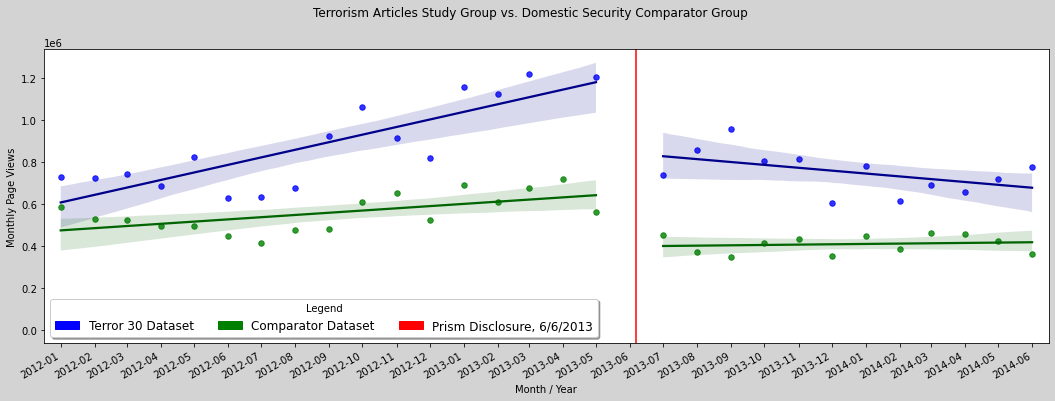

In [21]:
make_double_figure([terrorFinal, compFinal], ['Terror 30 Dataset', 'Comparator Dataset'], title='Terrorism Articles Study Group vs. Domestic Security Comparator Group')

As before, removing the outliers first of all narrows down the confidence intervals. Also, due to the removal of the UN article in the comparator group, the cumulated pageviews for this group go down significantly. However, the question of interest is not the overall page views, but whether the Prism Disclosure affects the two groups differently. Again, the answer is to the question is twofold:

There clearly is a drop in both groups in overall page views after June 2013. Although rising over time before that date, neither of the groups will reach the same number as pageviews as in the month before Edward Snowden released his information thorughout the following year.

Furthermore, the upwards trends for both curves seem to be stopped by the Prism affair. For the terror dataset, there even seems to be a long-term downwards trend after June 2013. In contrast to the terror group, the comparator group trend does not point downwoards but indicates constant pageviews over time. This finding supports the theory of chilling effects.

However, the paper makes statements about long term chilling effects that cannot fully be empirically proven by this analysis. Here, only one year of data after the Prism revelation is covered, which is way to short to show a long term effect that affects peoples behaviour for a significant time, even after news coverage of a certain event decreases. Also, again, the analysis covers only Wikipedia article views and not the total users only behaviour. Nevertheless, a change of trend is visible. The data does not prove anything, but strongly supports the theory of chilling effects.